# NREL DATA
## Import Libraries

In [1]:
# Upgrade the Package
!pip install --upgrade pip

# Package from the Python Package Index
!pip install pvlib

# Module netCDF4 was not found 
!pip install netCDF4

# Try to save Excel
!pip install openpyxl

# 4/20/2020: version 1.1.2 released. Code optimization, fix logic so only_use_cftime_datimes=False works as expected (issues #158 and #165). 
!pip install cftime==1.1.2

Requirement already up-to-date: pip in /home/nbuser/anaconda3_501/lib/python3.6/site-packages (20.1)


In [2]:
# Make basic imports and then set the location and time range data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pytz
import seaborn as sns; sns.set_color_codes()
import datetime
import pvlib

# Import pvlib forecast models
from pvlib import solarposition
from pvlib.location import Location
from matplotlib.pyplot import figure
from matplotlib import pyplot
%matplotlib inline

# Specify Location (Denver, CO)
latitude, longitude, tz = 39.7, -105.2, 'America/Denver'
start = pd.Timestamp(datetime.date.today(), tz=tz)
end = start + pd.Timedelta(days=4)


## May's First Week
### Irradiance 

In [24]:
# Read Irradiance data
nrel_df = pd.read_csv('May 3 to 8.txt')
print("Keys of nrel_df: \n{}".format(nrel_df.keys()))

Keys of nrel_df: 
Index(['DATE (MM/DD/YYYY)', 'MST', 'Global Horizontal [W/m^2]'], dtype='object')


In [25]:
# Columns Rename - Remove [ ]
nrel_df = nrel_df.rename(columns = {'Global Horizontal [W/m^2]': 'GHI', 'DATE (MM/DD/YYYY)': 'DATE'})

In [26]:
# Analyzing Data
# Global Horizonal & Direct Normal(W/m*2)
# Air Temperature (deg C)
nrel_df.describe()

,GHI
count,8640.000000
mean,296.981683
std,351.594869
min,0.000000
25%,0.000000
50%,90.346500
75%,621.754250
max,1217.850000


In [27]:
# Columns that contain NaN values (True = Nan value)
nrel_df.isnull().any()

DATE    False
MST     False
GHI     False
dtype: bool

In [28]:
nrel_df['Time'] = pd.to_datetime(nrel_df['MST'])

In [29]:
nrel_df['Time'].dt.hour + nrel_df['Time'].dt.minute/60

0        0.000000
1        0.016667
2        0.033333
3        0.050000
4        0.066667
5        0.083333
6        0.100000
7        0.116667
8        0.133333
9        0.150000
10       0.166667
11       0.183333
12       0.200000
13       0.216667
14       0.233333
15       0.250000
16       0.266667
17       0.283333
18       0.300000
19       0.316667
20       0.333333
21       0.350000
22       0.366667
23       0.383333
24       0.400000
25       0.416667
26       0.433333
27       0.450000
28       0.466667
29       0.483333
          ...    
8610    23.500000
8611    23.516667
8612    23.533333
8613    23.550000
8614    23.566667
8615    23.583333
8616    23.600000
8617    23.616667
8618    23.633333
8619    23.650000
8620    23.666667
8621    23.683333
8622    23.700000
8623    23.716667
8624    23.733333
8625    23.750000
8626    23.766667
8627    23.783333
8628    23.800000
8629    23.816667
8630    23.833333
8631    23.850000
8632    23.866667
8633    23.883333
8634    23

In [30]:
nrel_df['Time Float'] = nrel_df['Time'].dt.hour + nrel_df['Time'].dt.minute/60

In [31]:
nrel_df.rename(columns={'Time Float':'Hours', 'MST':'Time', 'Time':'MST'}, inplace=True)

In [32]:
nrel_df.head(10)

,DATE,Time,GHI,MST,Hours
0,5/3/2020,00:00,0.000000,2020-05-12 00:00:00,0.000000
1,5/3/2020,00:01,0.074087,2020-05-12 00:01:00,0.016667
2,5/3/2020,00:02,0.000000,2020-05-12 00:02:00,0.033333
3,5/3/2020,00:03,0.000000,2020-05-12 00:03:00,0.050000
4,5/3/2020,00:04,0.000000,2020-05-12 00:04:00,0.066667
5,5/3/2020,00:05,0.000000,2020-05-12 00:05:00,0.083333
6,5/3/2020,00:06,0.000000,2020-05-12 00:06:00,0.100000
7,5/3/2020,00:07,0.000000,2020-05-12 00:07:00,0.116667
8,5/3/2020,00:08,0.000000,2020-05-12 00:08:00,0.133333
9,5/3/2020,00:09,0.000000,2020-05-12 00:09:00,0.150000


In [33]:
nrel_df.tail(10)

,DATE,Time,GHI,MST,Hours
8630,5/8/2020,23:50,0.00000,2020-05-12 23:50:00,23.833333
8631,5/8/2020,23:51,0.00000,2020-05-12 23:51:00,23.850000
8632,5/8/2020,23:52,0.00000,2020-05-12 23:52:00,23.866667
8633,5/8/2020,23:53,0.00000,2020-05-12 23:53:00,23.883333
8634,5/8/2020,23:54,0.00000,2020-05-12 23:54:00,23.900000
8635,5/8/2020,23:55,0.00000,2020-05-12 23:55:00,23.916667
8636,5/8/2020,23:56,0.00000,2020-05-12 23:56:00,23.933333
8637,5/8/2020,23:57,0.00000,2020-05-12 23:57:00,23.950000
8638,5/8/2020,23:58,0.03705,2020-05-12 23:58:00,23.966667
8639,5/8/2020,23:59,0.00000,2020-05-12 23:59:00,23.983333


In [34]:
nrel_df = nrel_df[["DATE","MST","Time","Hours","GHI"]]

In [35]:
nrel_df.head()

,DATE,MST,Time,Hours,GHI
0,5/3/2020,2020-05-12 00:00:00,00:00,0.000000,0.000000
1,5/3/2020,2020-05-12 00:01:00,00:01,0.016667,0.074087
2,5/3/2020,2020-05-12 00:02:00,00:02,0.033333,0.000000
3,5/3/2020,2020-05-12 00:03:00,00:03,0.050000,0.000000
4,5/3/2020,2020-05-12 00:04:00,00:04,0.066667,0.000000


In [36]:
nrel_df.tail()

,DATE,MST,Time,Hours,GHI
8635,5/8/2020,2020-05-12 23:55:00,23:55,23.916667,0.00000
8636,5/8/2020,2020-05-12 23:56:00,23:56,23.933333,0.00000
8637,5/8/2020,2020-05-12 23:57:00,23:57,23.950000,0.00000
8638,5/8/2020,2020-05-12 23:58:00,23:58,23.966667,0.03705
8639,5/8/2020,2020-05-12 23:59:00,23:59,23.983333,0.00000


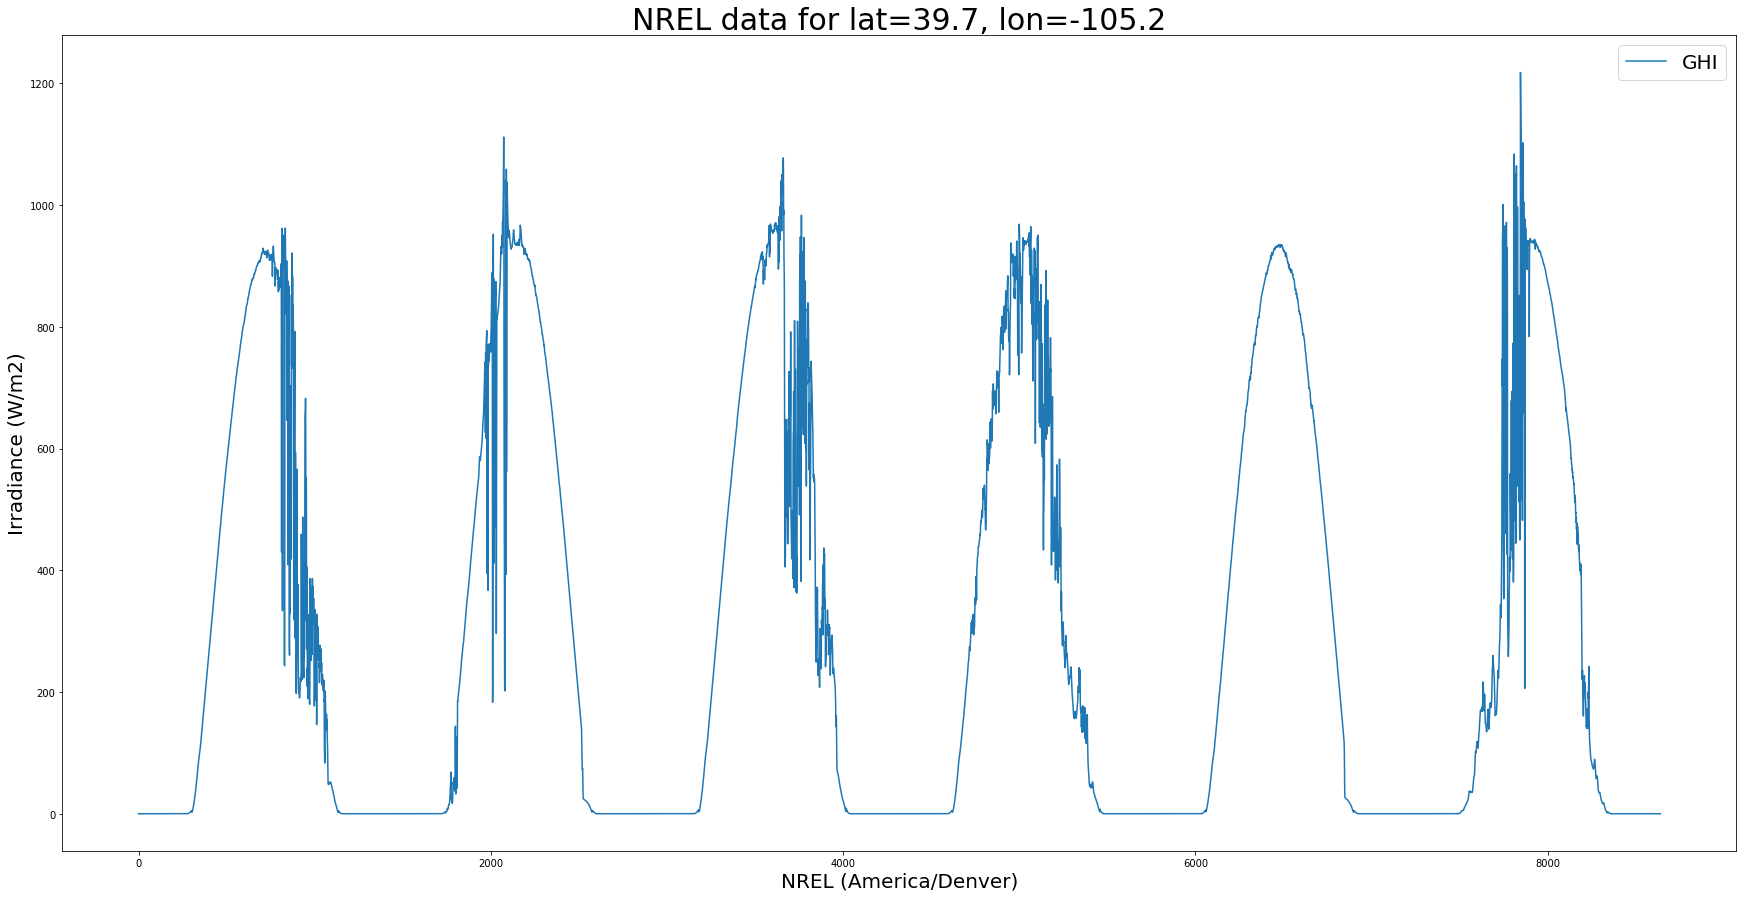

In [37]:
# Plot cloud cover percentages
irrad_var = ['GHI']
nrel_df[irrad_var].plot(figsize=(30,15));
plt.ylabel('Irradiance (W/m2)',size=20);
plt.xlabel('NREL ({})'.format(tz),size=20);
plt.title('NREL data for lat={}, lon={}'.format(latitude, longitude),size=30);
plt.legend(prop={'size': 20});

In [38]:
nrel_df_slice = nrel_df.iloc[::45] 

In [39]:
nrel_df_slice

,DATE,MST,Time,Hours,GHI
0,5/3/2020,2020-05-12 00:00:00,00:00,0.00,0.00000
45,5/3/2020,2020-05-12 00:45:00,00:45,0.75,0.00000
90,5/3/2020,2020-05-12 01:30:00,01:30,1.50,0.00000
135,5/3/2020,2020-05-12 02:15:00,02:15,2.25,0.00000
180,5/3/2020,2020-05-12 03:00:00,03:00,3.00,0.00000
225,5/3/2020,2020-05-12 03:45:00,03:45,3.75,0.00000
270,5/3/2020,2020-05-12 04:30:00,04:30,4.50,0.00000
315,5/3/2020,2020-05-12 05:15:00,05:15,5.25,18.22960
360,5/3/2020,2020-05-12 06:00:00,06:00,6.00,137.52200
405,5/3/2020,2020-05-12 06:45:00,06:45,6.75,282.93300


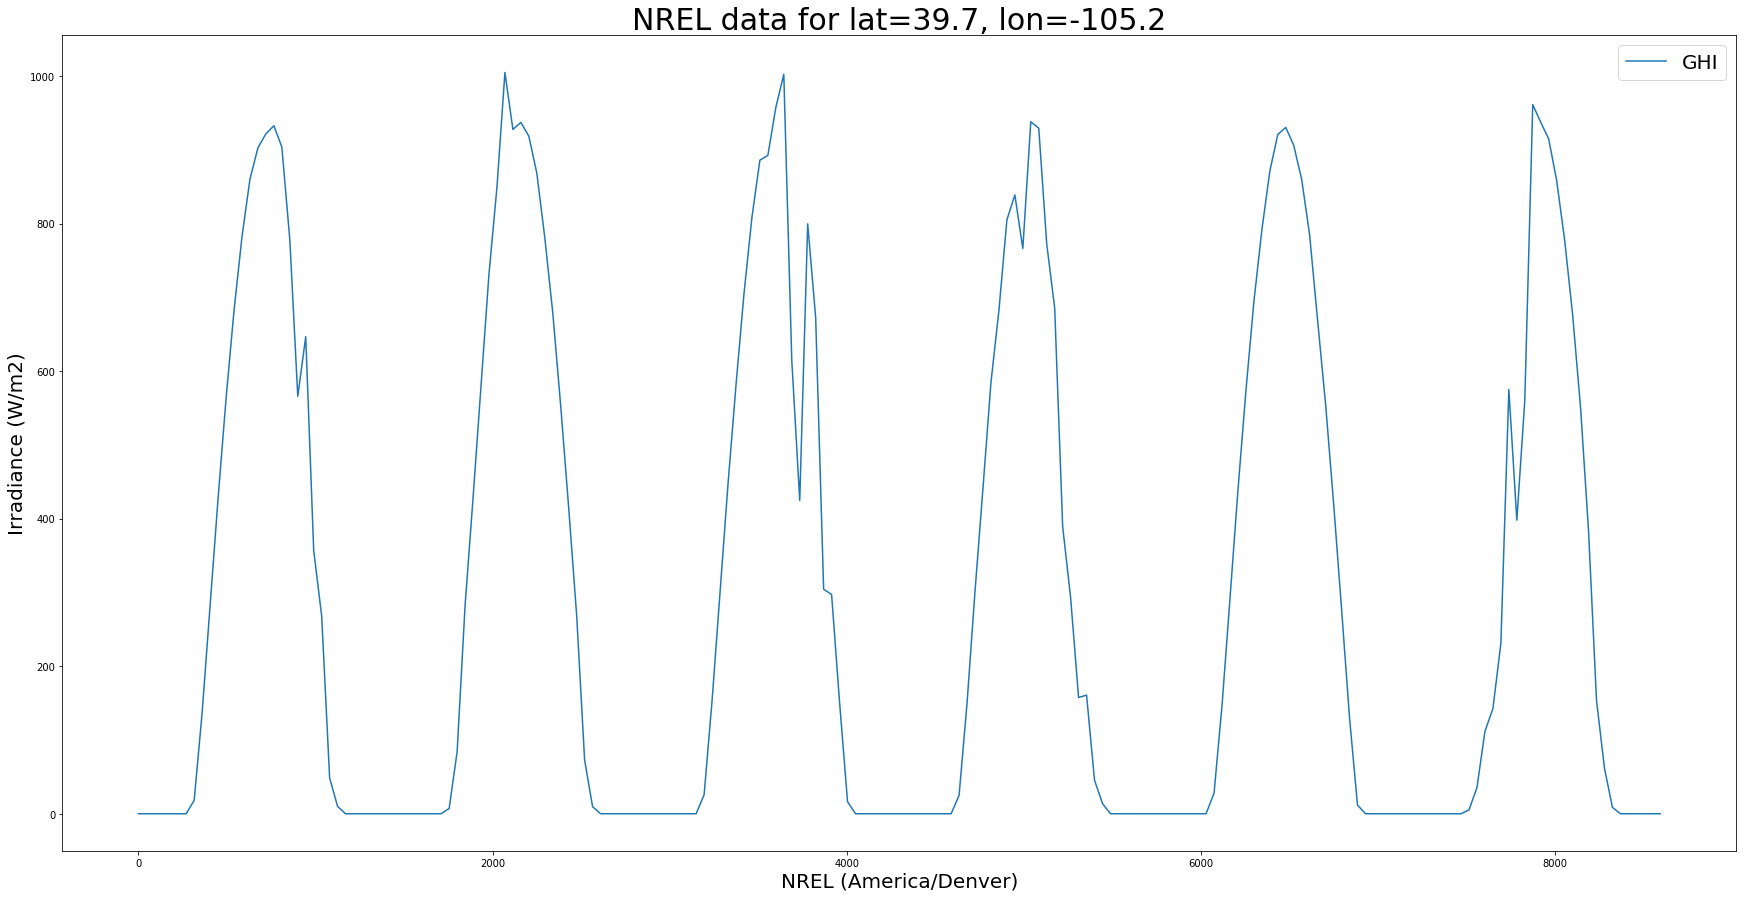

In [40]:
# Plot cloud cover percentages
irrad_var = ['GHI']
nrel_df_slice[irrad_var].plot(figsize=(30,15));
plt.ylabel('Irradiance (W/m2)', size=20);
plt.xlabel('NREL ({})'.format(tz), size=20);
plt.title('NREL data for lat={}, lon={}'.format(latitude, longitude), size=30);
plt.legend(prop={'size': 20});

In [41]:
nrel_df_ghi = nrel_df_slice['GHI']
nrel_df_ghi

0         0.00000
45        0.00000
90        0.00000
135       0.00000
180       0.00000
225       0.00000
270       0.00000
315      18.22960
360     137.52200
405     282.93300
450     427.71500
495     562.73100
540     682.17500
585     782.24500
630     860.21100
675     902.69000
720     921.61300
765     932.56500
810     903.68700
855     778.49100
900     565.87300
945     646.66500
990     356.77200
1035    268.07100
1080     48.42560
1125      9.89517
1170      0.00000
1215      0.00000
1260      0.00000
1305      0.00000
          ...    
7290      0.00000
7335      0.00000
7380      0.00000
7425      0.00000
7470      0.00000
7515      5.16045
7560     35.58990
7605    111.72900
7650    142.54700
7695    231.00000
7740    575.07000
7785    397.85900
7830    559.79700
7875    961.16400
7920    937.33300
7965    914.56300
8010    858.40500
8055    777.85300
8100    677.05800
8145    550.50100
8190    383.90300
8235    153.84800
8280     61.83210
8325      8.66232
8370      

In [54]:
nrel_df_ac = (nrel_df_ghi * 7648.75 * .1294 * 0.96 * .8 * 0.98)
nrel_df_ac

0            0.000000
45           0.000000
90           0.000000
135          0.000000
180          0.000000
225          0.000000
270          0.000000
315      13579.668790
360     102443.455227
405     210763.616859
450     318615.221218
495     419191.896592
540     508168.613526
585     582713.170502
630     640791.924667
675     672435.556483
720     686531.755660
765     694690.164654
810     673178.245833
855     579916.725345
900     421532.448186
945     481716.357922
990     265768.069168
1035    199692.554545
1080     36073.397605
1125      7371.150833
1170         0.000000
1215         0.000000
1260         0.000000
1305         0.000000
            ...      
7290         0.000000
7335         0.000000
7380         0.000000
7425         0.000000
7470         0.000000
7515      3844.143690
7560     26511.775041
7605     83229.627325
7650    106186.698944
7695    172077.472385
7740    428383.515345
7785    296374.766605
7830    417006.289216
7875    715994.249644
7920    69

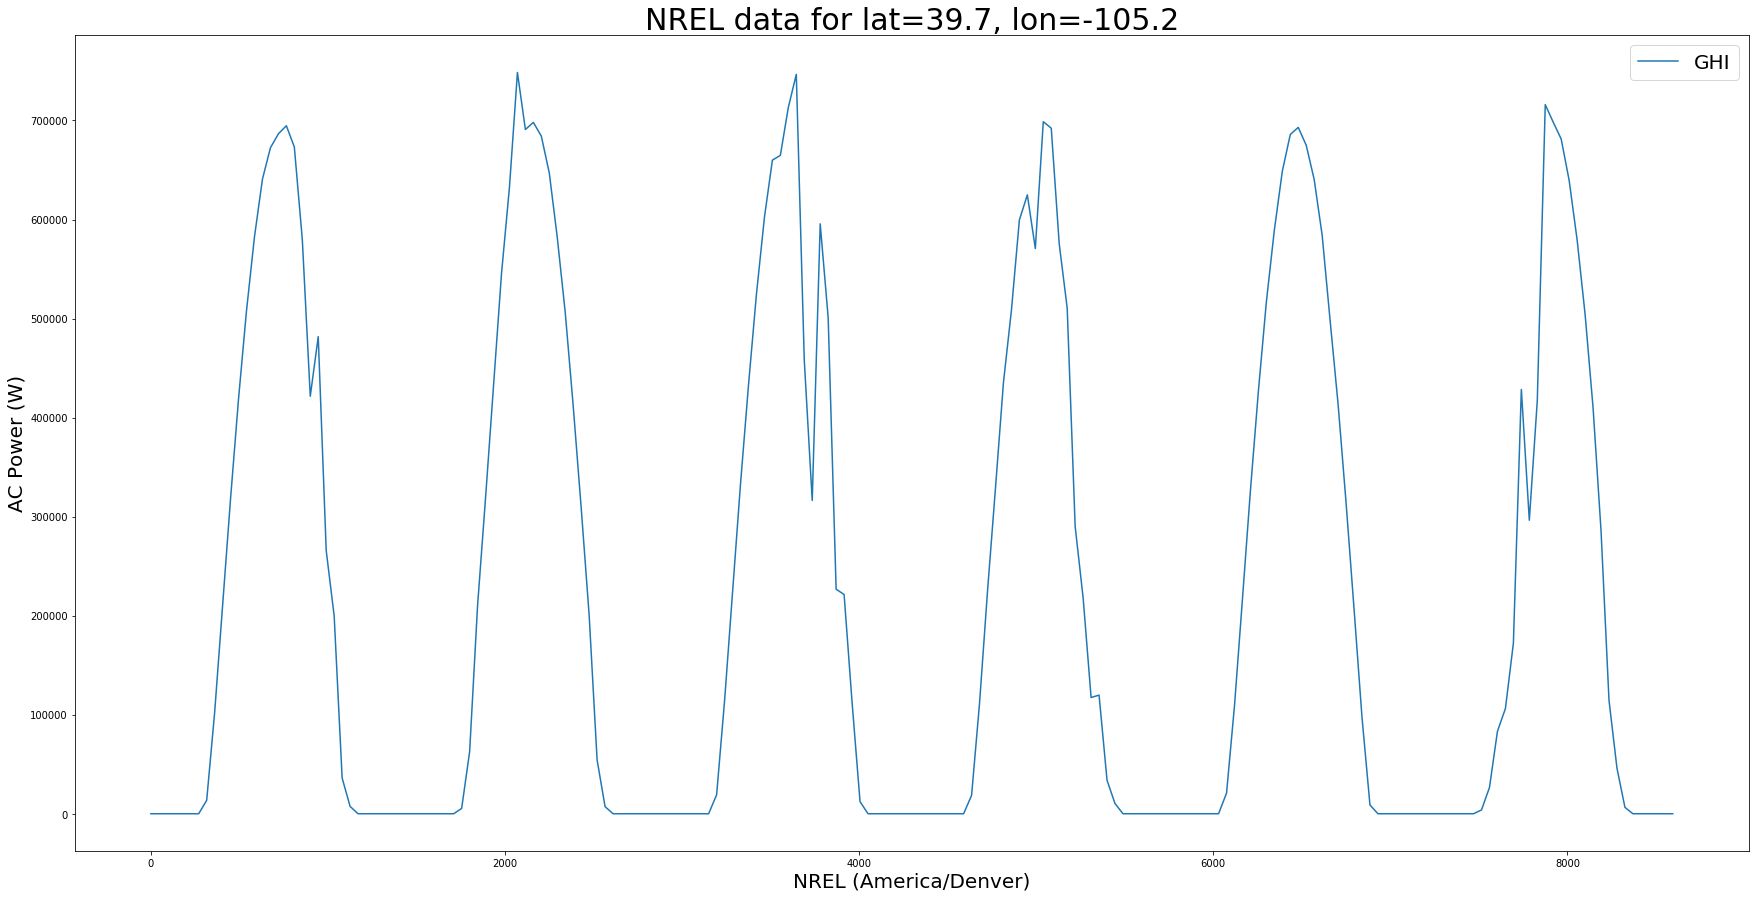

In [55]:
# Plot cloud cover percentages
nrel_df_ac.plot(figsize=(30,15));
plt.ylabel('AC Power (W)', size=20);
plt.xlabel('NREL ({})'.format(tz), size=20);
plt.title('NREL data for lat={}, lon={}'.format(latitude, longitude), size=30);
plt.legend(prop={'size': 20});

In [57]:
nrel_df_dc = (nrel_df_ghi * 7648.75 * .1294 * .8)
nrel_df_dc

0            0.000000
45           0.000000
90           0.000000
135          0.000000
180          0.000000
225          0.000000
270          0.000000
315      14434.171759
360     108889.727069
405     224025.953294
450     338664.138199
495     445569.617977
540     540145.209955
585     619380.495857
630     681113.865505
675     714748.678234
720     729731.883142
765     738403.661409
810     715538.101438
855     616408.083913
900     448057.449178
945     512028.441669
990     282491.570119
1035    212258.242501
1080     38343.322284
1125      7834.981753
1170         0.000000
1215         0.000000
1260         0.000000
1305         0.000000
            ...      
7290         0.000000
7335         0.000000
7380         0.000000
7425         0.000000
7470         0.000000
7515      4086.037085
7560     28180.032994
7605     88466.865779
7650    112868.515034
7695    182905.476600
7740    455339.620902
7785    315024.199197
7830    443246.480884
7875    761048.309570
7920    74

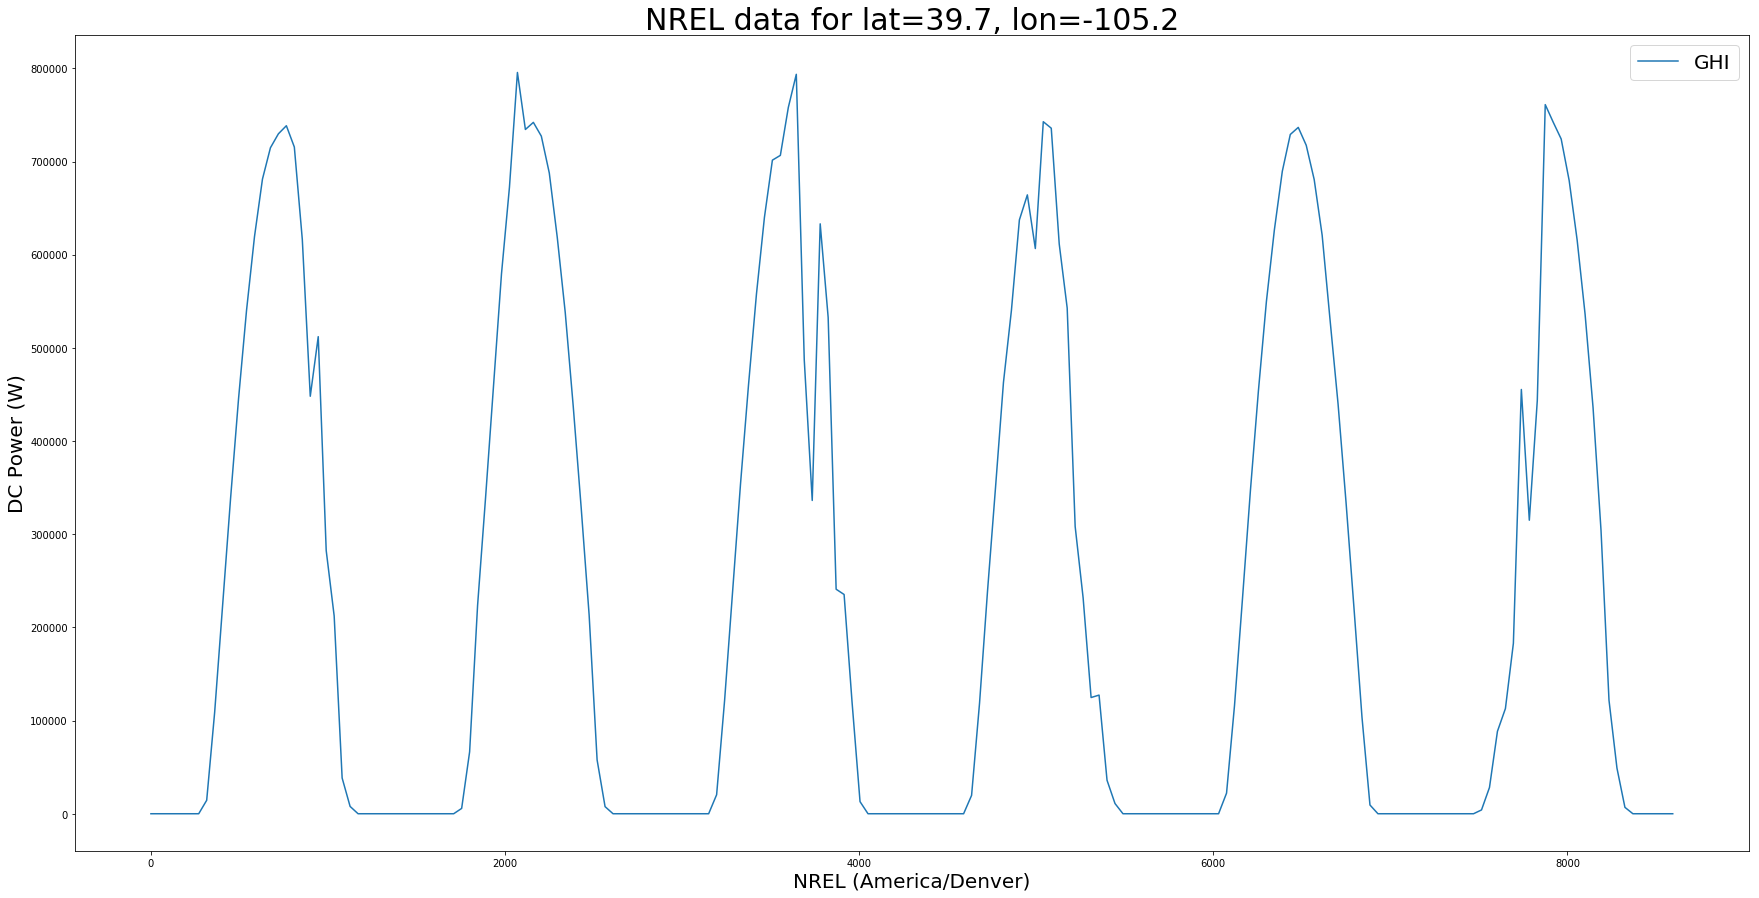

In [58]:
# Plot cloud cover percentages
nrel_df_dc.plot(figsize=(30,15));
plt.ylabel('DC Power (W)', size=20);
plt.xlabel('NREL ({})'.format(tz), size=20);
plt.title('NREL data for lat={}, lon={}'.format(latitude, longitude), size=30);
plt.legend(prop={'size': 20});

In [59]:
nrel_df_ac.describe()

count       192.000000
mean     225614.575912
std      264420.295029
min           0.000000
25%           0.000000
50%       72859.762088
75%      485759.433599
max      748469.961705
Name: GHI, dtype: float64

In [60]:
nrel_df_dc.describe()

count       192.000000
mean     239811.411471
std      281058.987063
min           0.000000
25%           0.000000
50%       77444.475008
75%      516325.928570
max      795567.561336
Name: GHI, dtype: float64

# PV System
## Design Philosophy
<p>The PVSystem class allows modelers to easily separate the data that represents a PV system from the data that influences the PV system.
<p>The data that represents the PV system is intrinsic. The data that influences the PV system is extrinsic.
<p>Intrinsic data is stored in object attributes. For example, the data that describes a PV system’s module parameters is stored in PVSystem.module_parameters.</p>

## PV System Attributes

In [110]:
# 20 deg tilt, south-facing
system = pvlib.pvsystem.PVSystem(surface_tilt=20, surface_azimuth=180)

In [111]:
print(system.surface_tilt, system.surface_azimuth)

20 180


In [112]:
# call get_aoi with solar_zenith, solar_azimuth
aoi = system.get_aoi(30, 180)

In [113]:
print(aoi)

9.999999999999975


In [114]:
# retrieve_sam returns a dict. the dict keys are module names,
# and the values are model parameters for that module
modules = pvlib.pvsystem.retrieve_sam('cecmod')
module_parameters = modules['Canadian_Solar_Inc__CS5P_220M']
inverters = pvlib.pvsystem.retrieve_sam('cecinverter')
inverter_parameters = inverters['ABB__MICRO_0_25_I_OUTD_US_208__208V_']
system = pvlib.pvsystem.PVSystem(module_parameters=module_parameters, inverter_parameters=inverter_parameters)

In [115]:
# crude numbers from a single module
data = pd.DataFrame({'v_mp': 8, 'v_oc': 10, 'i_mp': 5, 'i_x': 6, 'i_xx': 4, 'i_sc': 7, 'p_mp': 40}, index=[0])
data_scaled = system.scale_voltage_current_power(data)
print(data_scaled)

   v_mp  v_oc  i_mp  i_x  i_xx  i_sc  p_mp
0     8    10     5    6     4     7    40


# Model Chain
## Example - Import Libraries

In [116]:
# Import pvlib
from pvlib.pvsystem import PVSystem, retrieve_sam
from pvlib.location import Location
from pvlib.modelchain import ModelChain
from pvlib.tracking import SingleAxisTracker
from pvlib.temperature import TEMPERATURE_MODEL_PARAMETERS

In [118]:
# Load some module and inverter specifications
sandia_modules = pvlib.pvsystem.retrieve_sam('SandiaMod')
cec_inverters = pvlib.pvsystem.retrieve_sam('cecinverter')
module = sandia_modules['Canadian_Solar_CS5P_220M___2009_']
sandia_module = sandia_modules['Canadian_Solar_CS5P_220M___2009_']
cec_inverter = cec_inverters['ABB__MICRO_0_25_I_OUTD_US_208__208V_']
inverter = cec_inverters['ABB__MICRO_0_25_I_OUTD_US_208__208V_']
temperature_model_parameters = TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_glass']

# model a big tracker for more fun
tracker = SingleAxisTracker(module_parameters=module, inverter_parameters=inverter, temperature_model_parameters=temperature_model_parameters, modules_per_string=15, strings_per_inverter=300)

# Create Location object, a PVSystem and a ModuleChain
location = Location(latitude=39.7, longitude=-105.2)
system = PVSystem(surface_tilt=20, surface_azimuth=200, module_parameters=sandia_module, inverter_parameters=cec_inverter, temperature_model_parameters=temperature_model_parameters)

# fx is a common abbreviation for forecast
fx_model = GFS()
fx_data = fx_model.get_processed_data(latitude, longitude, start, end)
ac_data = fx_data.resample('5min').interpolate()

# use a ModelChain object to calculate modeling intermediates
mc = ModelChain(system, fx_model.location)

# extract relevant data for model chain
mc.run_model(ac_data)

In [119]:
# Print the Model Chain
print(mc)

ModelChain: 
  name: None
  orientation_strategy: None
  clearsky_model: ineichen
  transposition_model: haydavies
  solar_position_method: nrel_numpy
  airmass_model: kastenyoung1989
  dc_model: sapm
  ac_model: snlinverter
  aoi_model: sapm_aoi_loss
  spectral_model: sapm_spectral_loss
  temperature_model: sapm_temp
  losses_model: no_extra_losses


In [43]:
# Specify time range
start = pd.Timestamp(datetime.date.today(), tz=tz)
end = start + pd.Timedelta(days=4)
irrad_vars = ['ghi','dni','dhi']

# Run Model with simple Data 
weather = pd.DataFrame([[1050, 1000, 100, 30, 5]], columns=['ghi', 'dni', 'dhi', 'temp_air', 'wind_speed'], index=[pd.Timestamp('20200505 1200', tz='America/Denver')])
mc.run_model(weather);

In [44]:
mc.aoi

2020-05-05 12:00:00-06:00    20.811958
Name: aoi, dtype: float64

In [45]:
mc.cell_temperature

2020-05-05 12:00:00-06:00    57.299137
dtype: float64

In [46]:
mc.dc

,i_sc,i_mp,v_oc,v_mp,p_mp,i_x,i_xx
2020-05-05 12:00:00-06:00,5.345029,4.737896,52.390973,40.746596,193.05312,5.224805,3.327979


In [47]:
mc.ac

2020-05-05 12:00:00-06:00    185.930384
dtype: float64

# PV Power Forecast

In [48]:
# fx is a common abbreviation for forecast
fx_model = GFS()
fx_data = fx_model.get_processed_data(latitude, longitude, start, end)
ac_data = fx_data.resample('5min').interpolate()

# use a ModelChain object to calculate modeling intermediates
mc = ModelChain(system, fx_model.location)

# extract relevant data for model chain
mc.run_model(ac_data)

NameError: name 'GFS' is not defined

### ModelChain Attributes

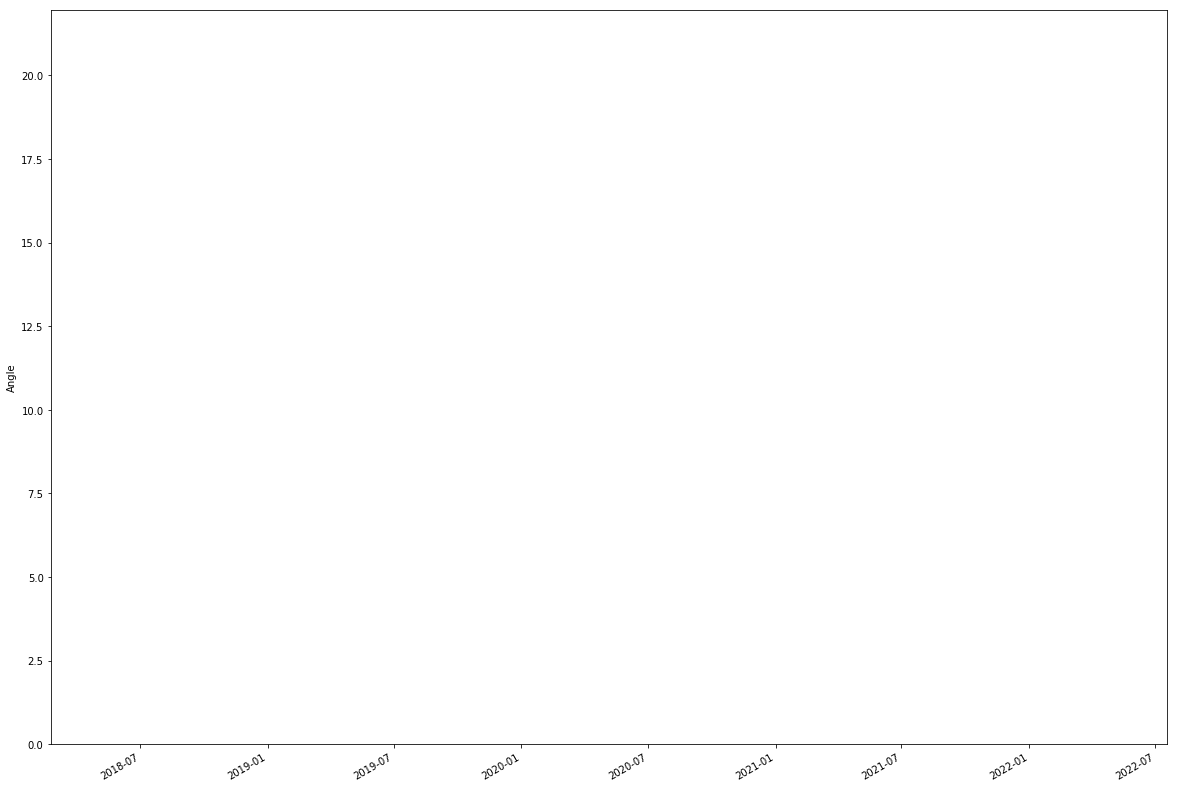

In [49]:
# ModelChain sotres modeling results on a series of attributes. 
# Angle of Incidence
mc.aoi.fillna(0).plot(figsize=(20,15));
plt.ylim(0, None);
plt.ylabel('Angle');

In [50]:
## Modeling intermediates & Forecast Power

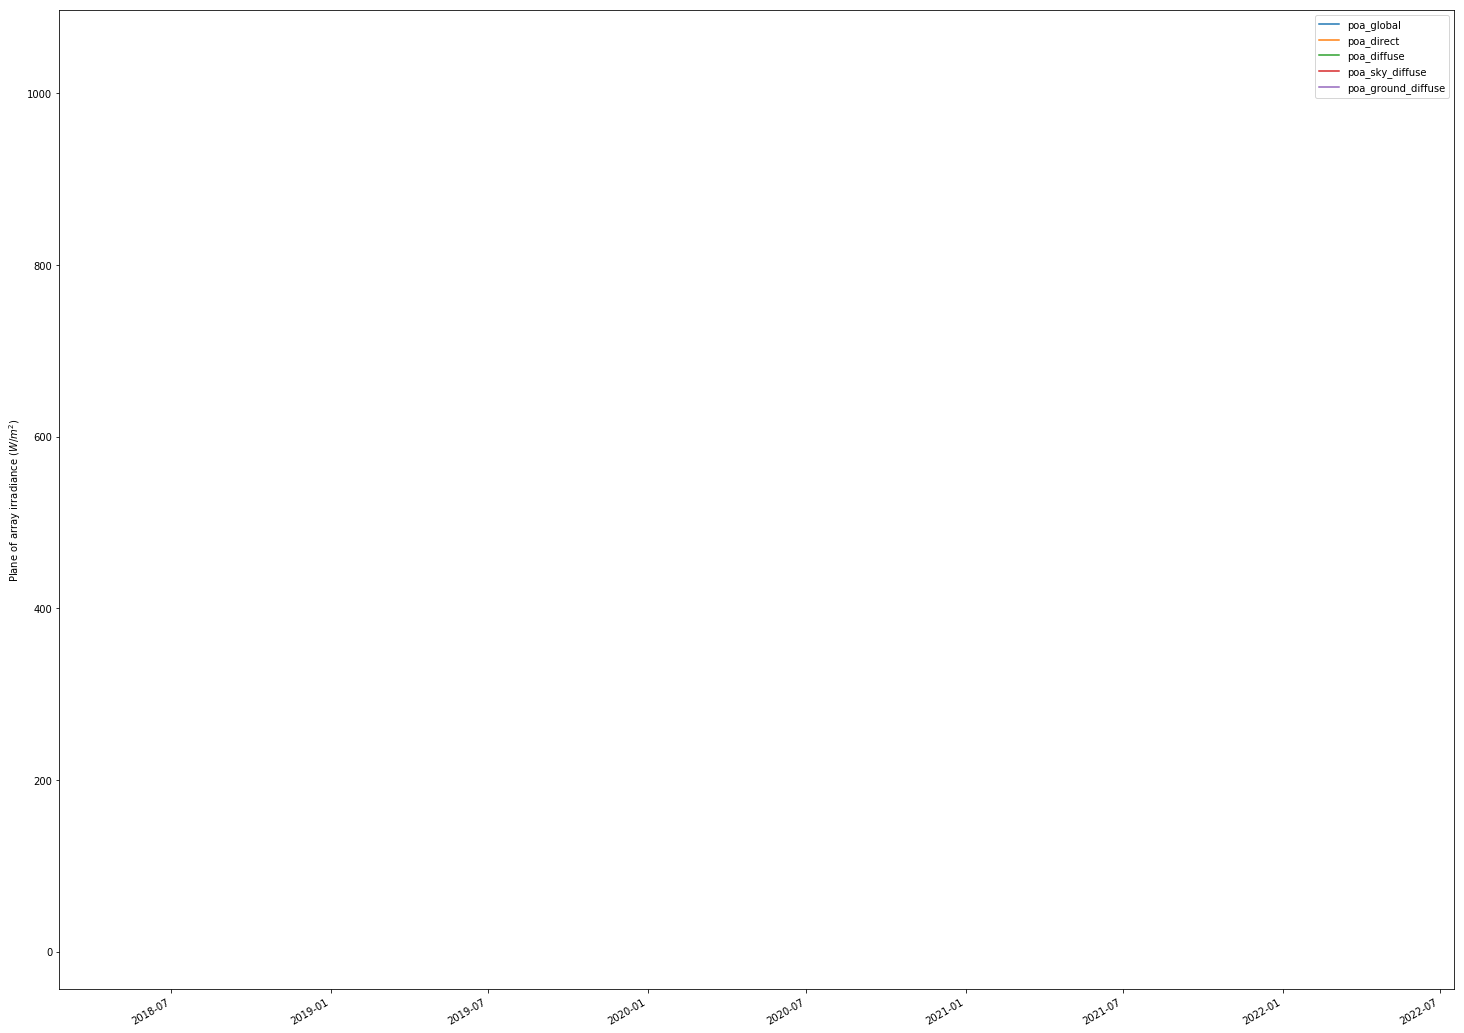

In [51]:
mc.total_irrad.plot(figsize=(25,20));
plt.ylabel('Plane of array irradiance ($W/m^2$)');
plt.legend(loc='best');

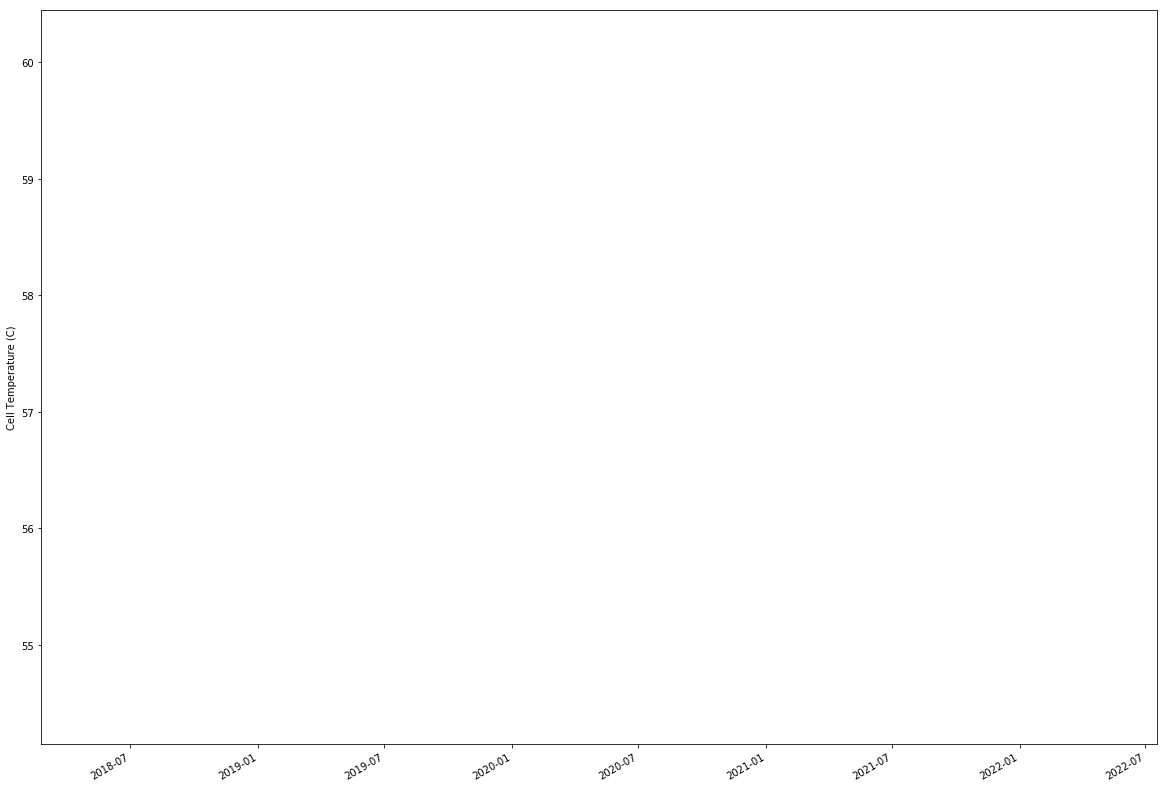

In [52]:
# Cell and module temperature
mc.cell_temperature.plot(figsize=(20,15));
plt.ylabel('Cell Temperature (C)');

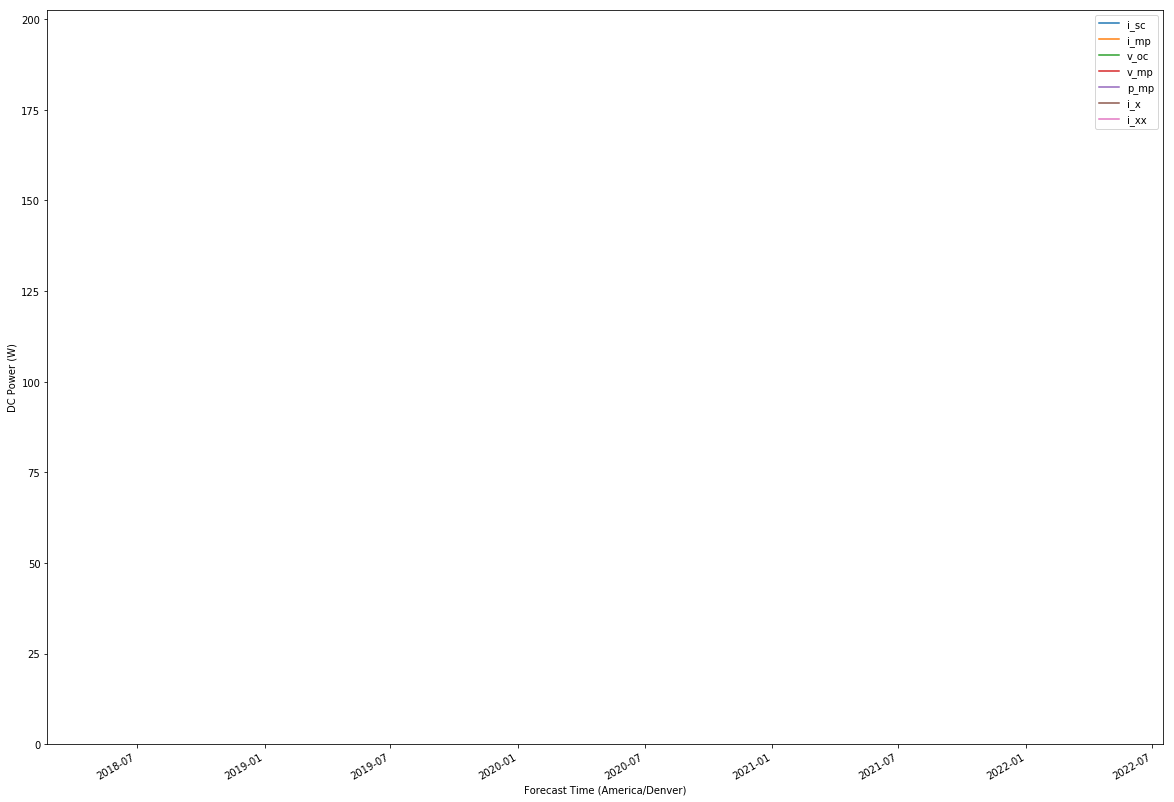

In [53]:
mc.dc.fillna(0).plot(figsize=(20,15));
plt.ylim(0, None);
plt.ylabel('DC Power (W)');
plt.xlabel('Forecast Time ({})'.format(tz));

In [54]:
mc.dc.describe()

,i_sc,i_mp,v_oc,v_mp,p_mp,i_x,i_xx
count,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000
mean,5.345029,4.737896,52.390973,40.746596,193.05312,5.224805,3.327979
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,5.345029,4.737896,52.390973,40.746596,193.05312,5.224805,3.327979
25%,5.345029,4.737896,52.390973,40.746596,193.05312,5.224805,3.327979
50%,5.345029,4.737896,52.390973,40.746596,193.05312,5.224805,3.327979
75%,5.345029,4.737896,52.390973,40.746596,193.05312,5.224805,3.327979
max,5.345029,4.737896,52.390973,40.746596,193.05312,5.224805,3.327979


In [55]:
mc.dc.fillna(0)

,i_sc,i_mp,v_oc,v_mp,p_mp,i_x,i_xx
2020-05-05 12:00:00-06:00,5.345029,4.737896,52.390973,40.746596,193.05312,5.224805,3.327979


In [56]:
mc.dc.fillna(0).to_csv('5 min DC.csv', encoding='utf-8')

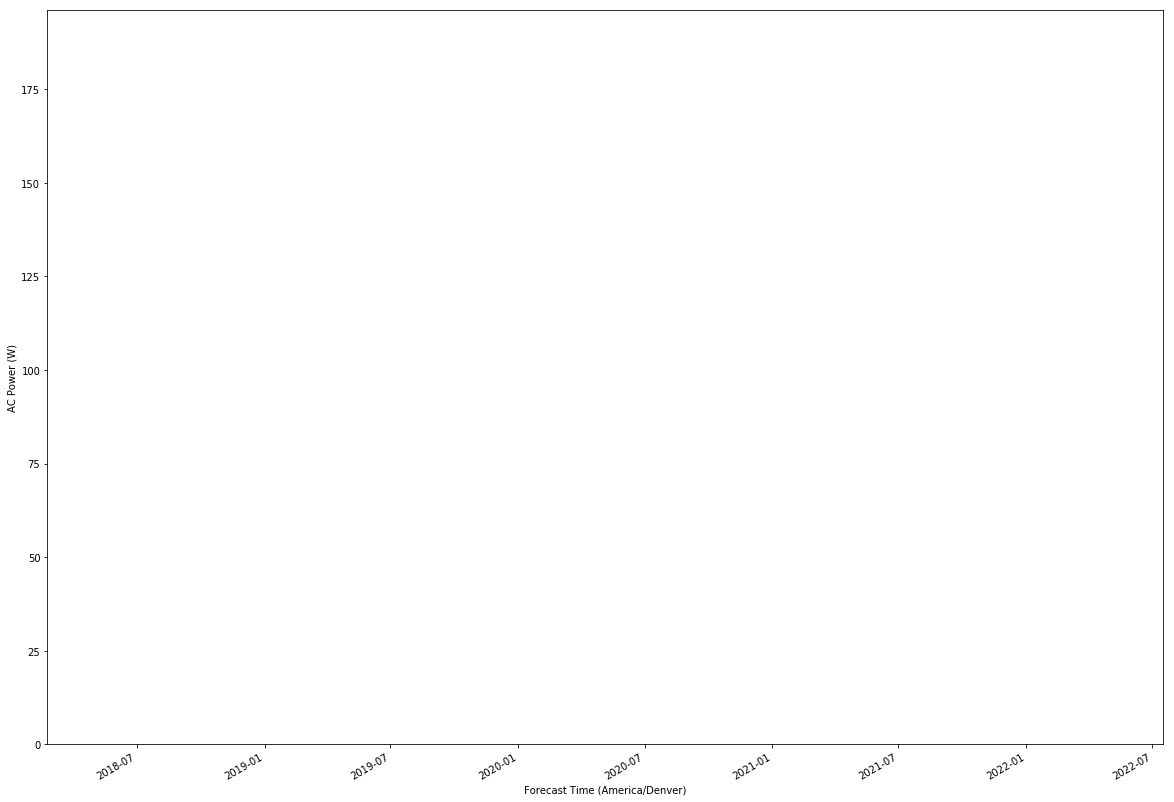

In [57]:
# AC Power
mc.ac.fillna(0).plot(figsize=(20,15));
plt.ylim(0, None);
plt.ylabel('AC Power (W)');
plt.xlabel('Forecast Time ({})'.format(tz));

In [58]:
mc.ac.fillna(0)

2020-05-05 12:00:00-06:00    185.930384
dtype: float64

In [59]:
mc.ac.describe()

count      1.000000
mean     185.930384
std             NaN
min      185.930384
25%      185.930384
50%      185.930384
75%      185.930384
max      185.930384
dtype: float64

In [60]:
mc.ac.fillna(0).to_csv('5 min AC.csv', encoding='utf-8')